In [46]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
from sklearn.model_selection import train_test_split

In [2]:
dataset_path = 'datasets/fake-br-corpus/full_texts.csv'

In [3]:
dataset = pd.read_csv(dataset_path)

In [4]:
dataset.label.value_counts()

fake    3600
true    3600
Name: label, dtype: int64

In [11]:
for category in dataset.category.unique():
    print('========', category, '========')
    print(dataset[dataset.category == category].label.value_counts())

======== politica ========
fake    2090
true    2090
Name: label, dtype: int64
======== sociedade_cotidiano ========
fake    638
true    638
Name: label, dtype: int64
======== tv_celebridades ========
fake    772
true    772
Name: label, dtype: int64
======== ciencia_tecnologia ========
fake    56
true    56
Name: label, dtype: int64
======== religiao ========
true    22
fake    22
Name: label, dtype: int64
======== economia ========
true    22
fake    22
Name: label, dtype: int64


In [5]:
train, test = train_test_split(dataset, test_size=0.25, stratify=dataset.label)

In [6]:
train.label.value_counts()

fake    2700
true    2700
Name: label, dtype: int64

In [7]:
test.label.value_counts()

fake    900
true    900
Name: label, dtype: int64

In [8]:
dataset.category.value_counts()

politica               4180
tv_celebridades        1544
sociedade_cotidiano    1276
ciencia_tecnologia      112
religiao                 44
economia                 44
Name: category, dtype: int64

# Preprocessing

In [14]:
import spacy
from spacy.lang.pt import STOP_WORDS

In [15]:
nlp = spacy.load('pt')
def lemmatize(text):
    global tokens
    tokens = nlp(text)
    lemmas = [token.lemma_ for token in tokens]
    return ' '.join(lemmas)

def cleanText(text):
    text = re.sub(r'[0-9"\(\)\,\:]+', ' ', text)
    text = re.sub(r'[\n ]+', ' ', text)
    text = text.lower()
    return text

def preprocess(text):
#     text = lemmatize(text)
    text = cleanText(text)
    return text

# Feature extraction

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
tfidf = TfidfVectorizer(
    preprocessor=preprocess,
    ngram_range=(1,3),
    max_features=1000
)

In [19]:
X = tfidf.fit_transform(train.text)

# Classification

In [20]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [21]:
clf1 = SVC()
clf1.fit(X, train.label)

/home/aldo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [25]:
clf2 = DecisionTreeClassifier()
clf2.fit(X, train.label)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [22]:
X_test = tfidf.transform(test.text)

In [29]:
from sklearn.metrics import classification_report, accuracy_score
def evaluate(clf):
    ypred = clf.predict(X_test)
    ytrue = test.label
    print(classification_report(ytrue, ypred))
    print('accuracy:', accuracy_score(ytrue, ypred))
    return ypred

In [30]:
ypred1 = evaluate(clf1)

              precision    recall  f1-score   support

        fake       0.93      0.77      0.84       900
        true       0.81      0.94      0.87       900

   micro avg       0.86      0.86      0.86      1800
   macro avg       0.87      0.86      0.86      1800
weighted avg       0.87      0.86      0.86      1800

accuracy: 0.8561111111111112


In [31]:
ypred2 = evaluate(clf2)

              precision    recall  f1-score   support

        fake       0.93      0.90      0.91       900
        true       0.90      0.93      0.91       900

   micro avg       0.91      0.91      0.91      1800
   macro avg       0.91      0.91      0.91      1800
weighted avg       0.91      0.91      0.91      1800

accuracy: 0.9133333333333333


In [32]:
def resultsPerCategory(ypred):
    for category in test.category.unique():
        print('========', category, '========')
        print(classification_report(test.label[test.category == category], ypred[test.category == category]))

In [33]:
resultsPerCategory(ypred2)

======== politica ========
              precision    recall  f1-score   support

        fake       0.93      0.89      0.91       523
        true       0.89      0.93      0.91       515

   micro avg       0.91      0.91      0.91      1038
   macro avg       0.91      0.91      0.91      1038
weighted avg       0.91      0.91      0.91      1038

======== tv_celebridades ========
              precision    recall  f1-score   support

        fake       0.94      0.91      0.92       211
        true       0.91      0.94      0.92       205

   micro avg       0.92      0.92      0.92       416
   macro avg       0.92      0.92      0.92       416
weighted avg       0.92      0.92      0.92       416

======== sociedade_cotidiano ========
              precision    recall  f1-score   support

        fake       0.91      0.91      0.91       140
        true       0.91      0.92      0.92       150

   micro avg       0.91      0.91      0.91       290
   macro avg       0.91      

In [34]:
test.category.value_counts()

politica               1038
tv_celebridades         416
sociedade_cotidiano     290
ciencia_tecnologia       31
religiao                 15
economia                 10
Name: category, dtype: int64

---

In [54]:
testNumWords = test.text.apply(lambda text: len(preprocess(text).split())).values

In [73]:
binYpred = np.where(ypred2 == 'fake', 1, 0)
binYtrue = np.where(test.label == 'fake', 1, 0)

In [66]:
proba2 = clf2.predict_proba(X_test)

In [96]:
df = pd.DataFrame({'pred': binYpred, 'true':binYtrue, 'wordCount':testNumWords})
# df = pd.DataFrame({'pred':ypred2, 'true':test.label, 'wordCount':testNumWords})
df0 = df[df.true == 0]
df1 = df[df.true == 1]

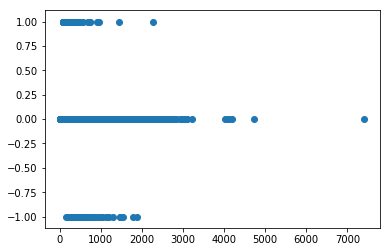

In [105]:
# plt.scatter(testNumWords, proba2.T[0])
# plt.scatter(testNumWords, binYtrue)
plt.scatter(df.wordCount, df.true - df.pred)

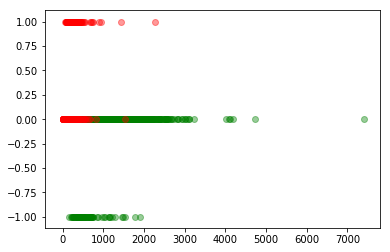

In [106]:
plt.scatter(df0.wordCount, df0.true - df0.pred, alpha=0.4, c='g')
plt.scatter(df1.wordCount, df1.true - df1.pred, alpha=0.4, c='r')

In [71]:
np.corrcoef(testNumWords, proba2.T[0])

array([[ 1.        , -0.63340384],
       [-0.63340384,  1.        ]])